In [1]:
import torch
from normalizing_flows.flows import Flow, PrincipalManifoldFlow
from normalizing_flows.bijections import RealNVP

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../')

from test.shapes import *

sys.path.remove('../')

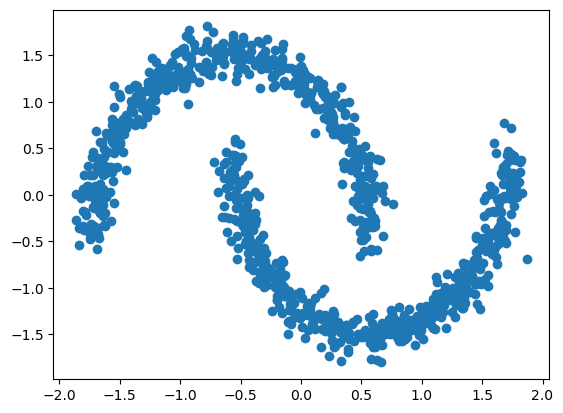

In [3]:
from sklearn.datasets import make_swiss_roll, make_moons
# data, y = make_swiss_roll(n_samples=100000, noise=0.5)
# data = data[:, [0, 2]]
data, y = make_moons(n_samples=1000, noise=0.06)
data = data - data.mean(axis=0)
data = data/data.std(axis=0)

data_tensor = torch.tensor(data, dtype=torch.float32)
n_dim = 2

plt.scatter(data_tensor[:, 0], data_tensor[:, 1])

plt.show()

In [4]:
# torch.manual_seed(0)
normal_flow = Flow(RealNVP(n_dim, n_layers=10), record_Ihat_P=True, record_log_px=True)
normal_flow.fit(data_tensor, show_progress=True)

Fitting NF: 100%|██████████| 500/500 [00:12<00:00, 40.89it/s, Training loss (batch): 0.7864]


In [5]:
# x = torch.tensor([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]).float()
# result = torch.vmap(normal_flow.bijection.forward, chunk_size=1)(x.unsqueeze(1))
# print(result)

In [6]:
# NF_log_px = normal_flow.get_log_px()
# NF_Ihat_P = normal_flow.get_Ihat_P()

# # print all
# print("NF_log_px: ", len(NF_log_px))
# print("NF log_px average: ", torch.mean(NF_log_px))
# print("NF_Ihat_P: ", len(NF_Ihat_P))
# print("NF Ihat_P average: ", torch.mean(NF_Ihat_P))

In [7]:
# # x = torch.tensor([[-0.5390, 0.5687, 0.3], [1.5736, 0.6144, -0.5], [-1.2372,  0.9555, 0.5]], requires_grad=True)
# x = torch.tensor([[-0.5390, 0.5687], [1.5736, 0.6144], [-1.2372,  0.9555]], requires_grad=True)

# z_test, log_det_test = normal_flow.bijection.forward(x)
# print(z_test)
# print(log_det_test)

# def _jacobian(_x):
#     _z, _log_det = normal_flow.bijection.forward(_x.unsqueeze(0))
#     _z = _z.squeeze(0)
#     _log_det = _log_det.squeeze(0)

#     jacobian = torch.stack([
#                 torch.autograd.grad(
#                     out_dim,
#                     _x,
#                     retain_graph=True,
#                     allow_unused=True,
#                     materialize_grads=True
#                 )[0] for out_dim in _z
#             ])
    
#     return _z, _log_det, jacobian

# results = [_jacobian(_x) for _x in x]
# z, log_det, jacobians = zip(*results)

# z = torch.stack(z)
# log_det = torch.stack(log_det)
# jacobian = torch.stack(jacobians)

# print(z)
# print(log_det)
# print(jacobian)

In [8]:
# def simple_func(x):
#     return torch.cos(x), (torch.cos(x), x.sum())

# x = torch.tensor([[-0.5390, 0.5687], [1.5736, 0.6144], [-1.2372,  0.9555]], requires_grad=True)
# # x = x.unsqueeze(1)

# # z = simple_func(x)[0]
# # print("z: ", z)

# z = normal_flow.bijection.forward(x)
# print("z: ", z)

# # jacobian_result = torch.func.jacrev(simple_func, has_aux=True)(x)
# # print("jacobian_result: ", jacobian_result)

# result = torch.vmap(lambda x: torch.func.jacrev(normal_flow.bijection.forward, has_aux=True)(x))(x)
# print("result: ", result)

In [9]:
torch.manual_seed(0)
PM_flow = PrincipalManifoldFlow(RealNVP(n_dim, n_layers=10), record_Ihat_P=True, record_log_px=True, debug=False, objective="brute_force")
PM_flow.fit(data_tensor, show_progress=True)

Fitting Principal Manifold Flow:   0%|          | 0/500 [00:00<?, ?it/s]

Fitting Principal Manifold Flow (1.739698, -5.059230): 100%|██████████| 500/500 [2:20:04<00:00, 16.81s/it, Training loss (batch): 13.7577]  


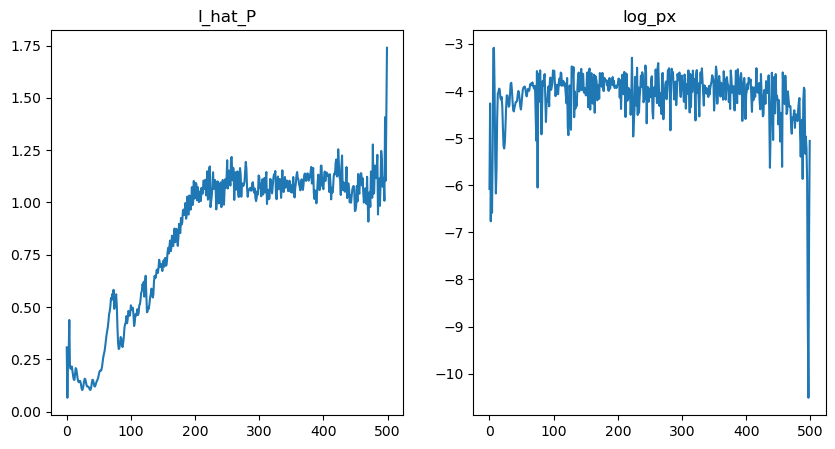

In [16]:
I_hat_P = PM_flow.get_Ihat_P()
log_px = PM_flow.get_log_px()

# print("I_hat_P: ", I_hat_P)
# print("I_hat_P average: ", torch.mean(I_hat_P))

# print("log_px: ", log_px)
# print("log_px average: ", torch.mean(log_px))

# plot I_hat_P and log_px
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(I_hat_P)
ax[0].set_title("I_hat_P")
ax[1].plot(log_px)
ax[1].set_title("log_px")
plt.show()


In [11]:
from scipy.stats import norm

N = 201
u_range = v_range = torch.linspace(1e-3, 1.0 - 1e-3, N)
u_range = torch.tensor(norm.ppf(u_range.numpy()))
v_range = torch.tensor(norm.ppf(v_range.numpy()))
u, v = torch.meshgrid(u_range, v_range, indexing='ij')
uv = torch.stack([u, v], axis=-1)
horiz_lines = uv[::10]
vert_lines = uv[:, ::10].permute(1, 0, 2)  


In [12]:
print(horiz_lines.shape)

torch.Size([21, 201, 2])


torch.Size([21, 201, 2])
torch.Size([21, 201, 2])


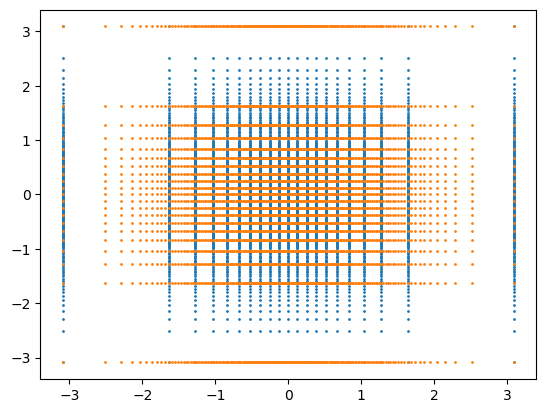

In [13]:
# plt.scatter(*horiz_lines.T, s=1.0)
# plt.scatter(*vert_lines.T, s=1.0)
# Check the shape of horiz_lines and vert_lines
print(horiz_lines.shape)
print(vert_lines.shape)

# Reshape or slice if necessary to get the right format (N, 2) for scatter
# If it's (N, 2), you're good to go, otherwise reshape as needed
horiz_lines_reshaped = horiz_lines.reshape(-1, 2).float()
vert_lines_reshaped = vert_lines.reshape(-1, 2).float()

# Now you can unpack these arrays correctly into scatter
plt.scatter(horiz_lines_reshaped[:, 0], horiz_lines_reshaped[:, 1], s=1.0)
plt.scatter(vert_lines_reshaped[:, 0], vert_lines_reshaped[:, 1], s=1.0)

plt.show()

In [14]:
# put all horizontal and vertical lines through the flow
horiz_lines_flow = PM_flow.bijection.forward(horiz_lines_reshaped)
vert_lines_flow = PM_flow.bijection.forward(vert_lines_reshaped)

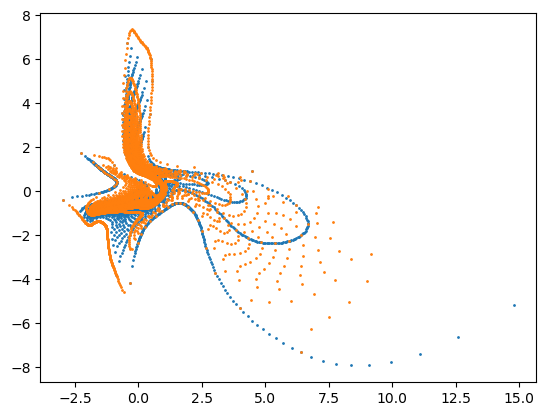

In [15]:
plt.scatter(horiz_lines_flow[0][:, 0].detach().numpy(), horiz_lines_flow[0][:, 1].detach().numpy(), s=1.0)
plt.scatter(vert_lines_flow[0][:, 0].detach().numpy(), vert_lines_flow[0][:, 1].detach().numpy(), s=1.0)
